<a href="https://colab.research.google.com/github/yanipark/2025_HighTecker-projects/blob/main/%EB%B6%84%EC%84%9D%EB%8D%B0%EC%9D%B4%ED%84%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
sub_od = pd.read_csv("/content/drive/MyDrive/2025하이테커/서울특별시_지하철 호선별 사용자 유형별 OD.csv", encoding = "cp949")
sub_free = pd.read_csv("/content/drive/MyDrive/2025하이테커/서울시 지하철 호선별 역별 유_무임 승하차 인원 정보.csv", encoding = "cp949")

In [3]:
display(sub_od)

,기준_날짜,승차_호선_명칭,하차_호선_명칭,승객_수,승객_수_일반,승객_수_어린이,승객_수_청소년,승객_수_경로,승객_수_장애인,승객_수_국가유공자,승객_수_외국인경로
0,2024-06-01,1호선,1호선,50357,30809,1038,571,15187,2550,174,28
1,2024-06-01,1호선,2호선,20991,15918,442,437,3532,598,39,25
2,2024-06-01,1호선,3호선,16732,11724,354,208,3820,570,48,8
3,2024-06-01,1호선,4호선,23262,17276,654,398,4250,643,35,6
4,2024-06-01,1호선,경부선,30027,21743,693,469,6020,1009,93,0
...,...,...,...,...,...,...,...,...,...,...,...
95,2024-06-01,3호선,8호선,8942,6692,242,183,1595,222,7,1
96,2024-06-01,3호선,인천1호선,1034,797,16,22,171,25,2,1
97,2024-06-01,3호선,인천2호선,612,466,12,14,104,16,0,0
98,2024-06-01,3호선,7호선(인천),2359,1936,48,70,264,37,2,2


In [4]:
## 여러개의 컬럼명 변경##
sub_od = sub_od.rename(columns={
    "기준_날짜": "date",
    "승차_호선_명칭": "line_from",
    "하차_호선_명칭": "line_to",
    "승객_수": "total_passengers",
    "승객_수_일반": "adult",
    "승객_수_어린이": "child",
    "승객_수_청소년": "teen",
    "승객_수_경로": "senior",
    "승객_수_장애인": "disabled",
    "승객_수_국가유공자": "patriot",
    "승객_수_외국인경로": "foreigner_senior"
})
sub_od.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              100 non-null    object
 1   line_from         100 non-null    object
 2   line_to           100 non-null    object
 3   total_passengers  100 non-null    int64 
 4   adult             100 non-null    int64 
 5   child             100 non-null    int64 
 6   teen              100 non-null    int64 
 7   senior            100 non-null    int64 
 8   disabled          100 non-null    int64 
 9   patriot           100 non-null    int64 
 10  foreigner_senior  100 non-null    int64 
dtypes: int64(8), object(3)
memory usage: 8.7+ KB


In [5]:
### 호선별 랭킹 확인###
ranking = (
    sub_od.groupby("line_to")["total_passengers"]
      .sum()
      .sort_values(ascending=False)
)

print("=== 호선별 전체 승객수 순위 ===")
print(f"{ranking.index[0]}: {ranking.iloc[0]:,}명")

print("=== 호선별 전체 승객수 TOP 10 ===")
ranking.head(10)


=== 호선별 전체 승객수 순위 ===
2호선: 703,846명
=== 호선별 전체 승객수 TOP 10 ===


,total_passengers
line_to,
2호선,703846
3호선,238971
4호선,114105
5호선,91107
7호선,89175
1호선,86089
경부선,73556
6호선,73308
경인선,47648


In [6]:
######################## EDA  #################################
"""
월임대료 컬럼 정리: 월임대료가 있는 행만 필터링
- 계약기간 계산: 종료일 - 시작일 → 개월 수
- 면적당 임대료: 월임대료 ÷ 면적 → 단위면적당 비용
- 업종 분류 정리: 유사 업종 통합 (예: 패션/의류, 식음료/카페 등)
"""
sub_fee = pd.read_csv("/content/drive/MyDrive/2025하이테커/서울교통공사_지하상가임대정보_20250930 (1).csv", encoding = "cp949")
display(sub_fee)

,연번,상가유형,호선,역명,면적(제곱미터),영업업종,계약시작일자,계약종료일자,월임대료,사업진행단계
0,1,브랜드전문,1호선,서울역,12.00,패션,2023-01-16,2028-05-16,3225582.0,NaN
1,2,입찰진행,1호선,시청,29.73,NaN,NaN,NaN,NaN,3단계. 감정평가
2,3,개별(일반),1호선,시청,57.60,기타,2020-02-01,2030-01-31,1951200.0,NaN
3,4,개별(일반),1호선,시청,25.00,플라워,2020-12-31,2026-01-30,2470600.0,NaN
4,5,소송상가,1호선,시청,25.00,식음료,2021-06-03,2026-08-02,4145884.0,NaN
...,...,...,...,...,...,...,...,...,...,...
1508,1509,브랜드전문,8호선,신흥역,40.00,편의점,2022-02-03,2027-05-04,4391715.0,NaN
1509,1510,브랜드전문,8호선,수진역,40.00,편의점,2022-02-03,2027-05-04,4036829.0,NaN
1510,1511,공실,8호선,모란역,50.00,NaN,NaN,NaN,NaN,1단계. 사업계획 수립중
1511,1512,개별(일반),8호선,남위례역,25.97,기타,2025-02-17,2030-03-19,1219300.0,NaN


In [7]:
#전처리
sub_fee["사업진행단계"].fillna("",inplace=True)
#sub_fee.drop("연번", axis=1, inplace=True)

# 3. 정수형으로 변환
sub_fee["월임대료"].fillna(0,inplace=True)
sub_fee["월임대료"] = sub_fee["월임대료"].astype(int)
#display(sub_fee)
sub_fee1 = sub_fee.copy()
sub_fee1["면적당 임대료"] = sub_fee1["월임대료"]/ sub_fee1["면적(제곱미터)"]
sub_fee1["면적당 임대료"] = sub_fee["월임대료"].astype(int)
#display(sub_fee1)

#계약 날짜 전처리
#print(sub_fee1["계약시작일자"].isna().sum())   #na = 156
sub_fee1 = sub_fee1.dropna(subset=["계약시작일자"])
sub_fee1 = sub_fee1.dropna(subset=["계약종료일자"])

#sub_fee1["계약기간"]
sub_fee1["계약시작일자"] = pd.to_datetime(sub_fee1["계약시작일자"])
sub_fee1["계약종료일자"] = pd.to_datetime(sub_fee1["계약종료일자"])
sub_fee1["계약기간"] = sub_fee1["계약종료일자"] - sub_fee1["계약시작일자"]
sub_fee1["계약기간(개월)"] = (sub_fee1["계약기간"].dt.days // 30) # // => 정수로 변환
sub_fee1["총임대료"] = sub_fee1["면적당 임대료"] * sub_fee1["계약기간(개월)"]
display(sub_fee1)
print(sub_fee1["영업업종"].value_counts())

,연번,상가유형,호선,역명,면적(제곱미터),영업업종,계약시작일자,계약종료일자,월임대료,사업진행단계,면적당 임대료,계약기간,계약기간(개월),총임대료
0,1,브랜드전문,1호선,서울역,12.00,패션,2023-01-16,2028-05-16,3225582,,3225582,1947 days,64,206437248
2,3,개별(일반),1호선,시청,57.60,기타,2020-02-01,2030-01-31,1951200,,1951200,3652 days,121,236095200
3,4,개별(일반),1호선,시청,25.00,플라워,2020-12-31,2026-01-30,2470600,,2470600,1856 days,61,150706600
4,5,소송상가,1호선,시청,25.00,식음료,2021-06-03,2026-08-02,4145884,,4145884,1886 days,62,257044808
5,6,개별(일반),1호선,시청,14.00,패션,2017-09-19,2027-11-17,1878100,,1878100,3711 days,123,231006300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1507,1508,개별(일반),8호선,단대오거리역,75.09,패션,2021-03-18,2026-04-17,3780000,,3780000,1856 days,61,230580000
1508,1509,브랜드전문,8호선,신흥역,40.00,편의점,2022-02-03,2027-05-04,4391715,,4391715,1916 days,63,276678045
1509,1510,브랜드전문,8호선,수진역,40.00,편의점,2022-02-03,2027-05-04,4036829,,4036829,1916 days,63,254320227
1511,1512,개별(일반),8호선,남위례역,25.97,기타,2025-02-17,2030-03-19,1219300,,1219300,1856 days,61,74377300


영업업종
패션       387
식음료      305
기타       222
편의점      170
플라워       83
화장품       64
의약업       56
사무실       29
무인프린트     27
밀키트        6
공유오피스      5
화상면접       3
Name: count, dtype: int64


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.


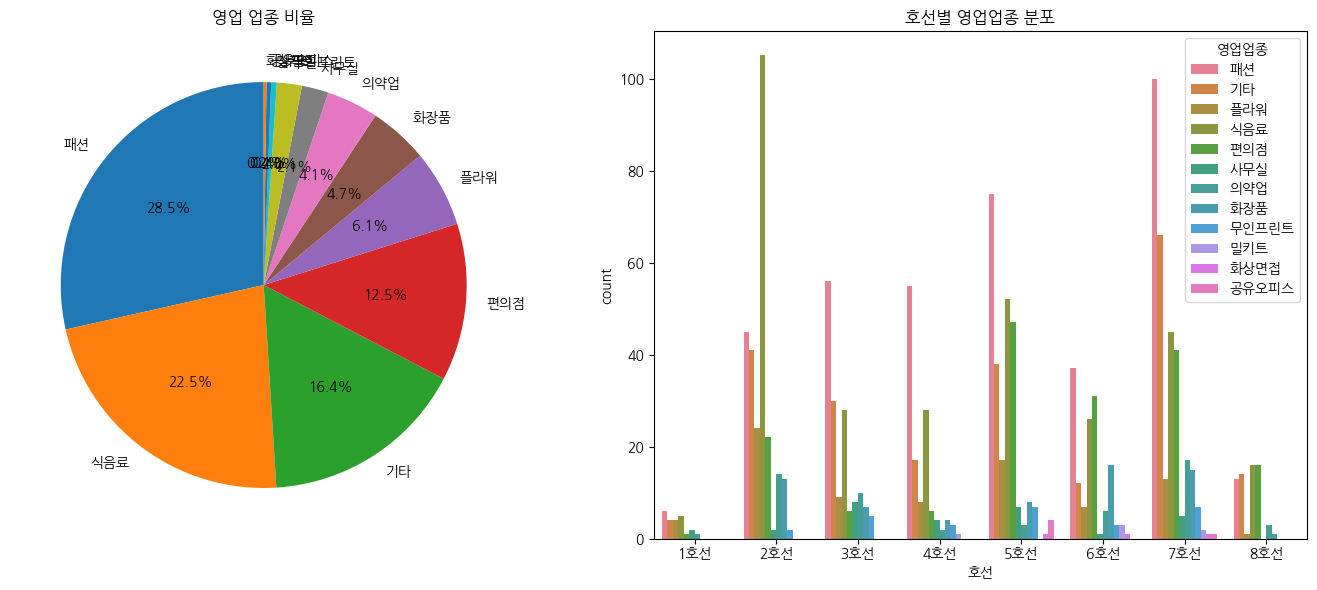

In [47]:
###### 폰트 설치
# 1. 나눔폰트 설치
!apt-get update -qq
!apt-get install -y fonts-nanum

# 2. matplotlib에 폰트 적용
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

##### 영업업종 빈도수 시각화
counts = sub_fee1["영업업종"].value_counts()

plt.figure(figsize=(14,6))  # 전체 figure 크기

# 1️⃣ 왼쪽: 파이 차트
plt.subplot(1, 2, 1)  # 1행 2열 중 첫 번째
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("영업 업종 비율")

# 2️⃣ 오른쪽: 막대 차트
plt.subplot(1, 2, 2)  # 1행 2열 중 두 번째
sns.countplot(data=sub_fee1, x="호선", hue="영업업종")
plt.title("호선별 영업업종 분포")

plt.tight_layout()  # 그래프 간격 조정
plt.show()

In [9]:
############### 기술통계 : 평균, 비교, 분산, 중앙값
#### 중심화 경향: 산술평균, 중앙값, 최빈값, 기하평균, 가중평균
#### 분산:
#### 표준편차(데이터분포): 표준편차가 작다; 평균에 몰려있음

############### 시각화
#### 패턴 및 추세 식별
#### 이상치 탐지
#### 상관 관계 및 인과 관계 부석 (연속형만 가)
#### 데이터 분포 이해
#### 비교와 분류
#### 의사 결정과 의사소통

In [33]:
"""
2. 역별 분석
- 역별 평균 월임대료
- 역별 평균 면적당 임대료
- 역별 업종 다양성
- 역별 총 상가 수
"""

sub_fee1.groupby("역명")["월임대료"].mean()
sub_fee1.groupby("역명")["면적당 임대료"].mean()

#가장 많이 나온 패션과 식음료만 분석
filtered = sub_fee1[sub_fee1["영업업종"].isin(["패션", "식음료","편의점"])]


# 역명별로 영업 업종 카운트
result = filtered.groupby("역명")["영업업종"].value_counts()

result_sorted = result.sort_values(ascending=False)
# 역별 업종 top 10 #
print("# 역별 업종 top 10 #\n")
print(result_sorted[:9])

#업종과 임대료 데이터 테이블 합치기
count_df = filtered.groupby(["역명", "영업업종"]).size().unstack(fill_value=0)
rent_df = sub_fee1.groupby("역명")["면적당 임대료"].mean().to_frame()

# index = 역명 기준으로 합치기
final_df = count_df.join(rent_df)

# 계산 가능 컬럼 따로, 보기 좋게 임대료 표시
final_df["면적당 임대료(보고용)"] = final_df["면적당 임대료"].map(lambda x: f"{x:,.0f}")
print("# 역별 업종과 면적당 임대료\n")
final_df

# 역별 업종 top 10 #

역명     영업업종
고속터미널  패션      29
잠실     식음료     17
노원     패션      15
오목교역   식음료     13
천호     패션      13
사당     패션      13
공덕     패션      11
태릉입구   패션      10
고속터미널  식음료     10
Name: count, dtype: int64
# 역별 업종과 면적당 임대료



,식음료,패션,편의점,면적당 임대료,면적당 임대료(보고용)
역명,,,,,
가락시장,2,1,1,2.811292e+06,"2,811,292"
가산디지털단지역,1,0,1,7.314944e+06,"7,314,944"
강남구청역,0,4,1,3.141837e+06,"3,141,837"
강남역,1,1,0,1.389067e+07,"13,890,667"
강동구청역,1,2,1,3.330245e+06,"3,330,245"
...,...,...,...,...,...
홍제역,1,0,0,2.444270e+07,"24,442,700"
화곡역,1,4,1,7.592567e+06,"7,592,567"
화랑대역,1,1,1,2.722911e+06,"2,722,911"


In [46]:
#마우스 오버, 확대/이동이 가능한 인터랙티브 시각화.
import plotly.graph_objects as go
import pandas as pd

# ----------------------------------------
# 1) 역명별 최다 업종 + Count 계산
# ----------------------------------------
count_df = (
    filtered.groupby(["역명", "영업업종"])
    .size()
    .reset_index(name="count")
)

# 각 역에서 가장 많은 업종 1개 선택
idx = count_df.groupby("역명")["count"].idxmax()
top_df = count_df.loc[idx].reset_index(drop=True)

# ----------------------------------------
# 2) Top 1 찾기
# ----------------------------------------
max_count = top_df["count"].max()
top_row = top_df[top_df["count"] == max_count].iloc[0]
top_station = top_row["역명"]

# ----------------------------------------
# 3) 업종별로 색상 다르게 Bar 생성
# ----------------------------------------
fig = go.Figure()

# 패션 bar
fashion_df = top_df[top_df["영업업종"] == "패션"]
fig.add_trace(
    go.Bar(
        x=fashion_df["역명"],
        y=fashion_df["count"],
        name="패션",
        marker_color="rgba(55, 83, 109, 0.8)"   # Plotly 기본계열 중 하나
    )
)

# 식음료 bar
food_df = top_df[top_df["영업업종"] == "식음료"]
fig.add_trace(
    go.Bar(
        x=food_df["역명"],
        y=food_df["count"],
        name="식음료",
        marker_color="rgba(26, 118, 255, 0.8)"
    )
)

# 식음료 bar
food_df = top_df[top_df["영업업종"] == "편의점"]
fig.add_trace(
    go.Bar(
        x=food_df["역명"],
        y=food_df["count"],
        name="편의점",
        marker_color= "rgba(255, 215, 0, 0.8)"
    )
)



# ----------------------------------------
# 4) Marker 추가 (Top 1)
# ----------------------------------------
fig.add_trace(
    go.Scatter(
        x=[top_station],
        y=[max_count],
        mode="markers+text",
        marker=dict(size=22, symbol="circle", color="red"),
        text=["TOP 1"],
        textposition="top center",
        name="Top 1 Marker"
    )
)

# ----------------------------------------
# 5) Layout
# ----------------------------------------
fig.update_layout(
    title="역명별 최다 업종 Count (업종별 색 + Top 1 Marker 강조)",
    xaxis_title="역명",
    yaxis_title="Count",
    barmode="group",  # 업종별로 나란히 표시
    legend_title="영업업종",
    template="plotly_white"
)

fig.show()


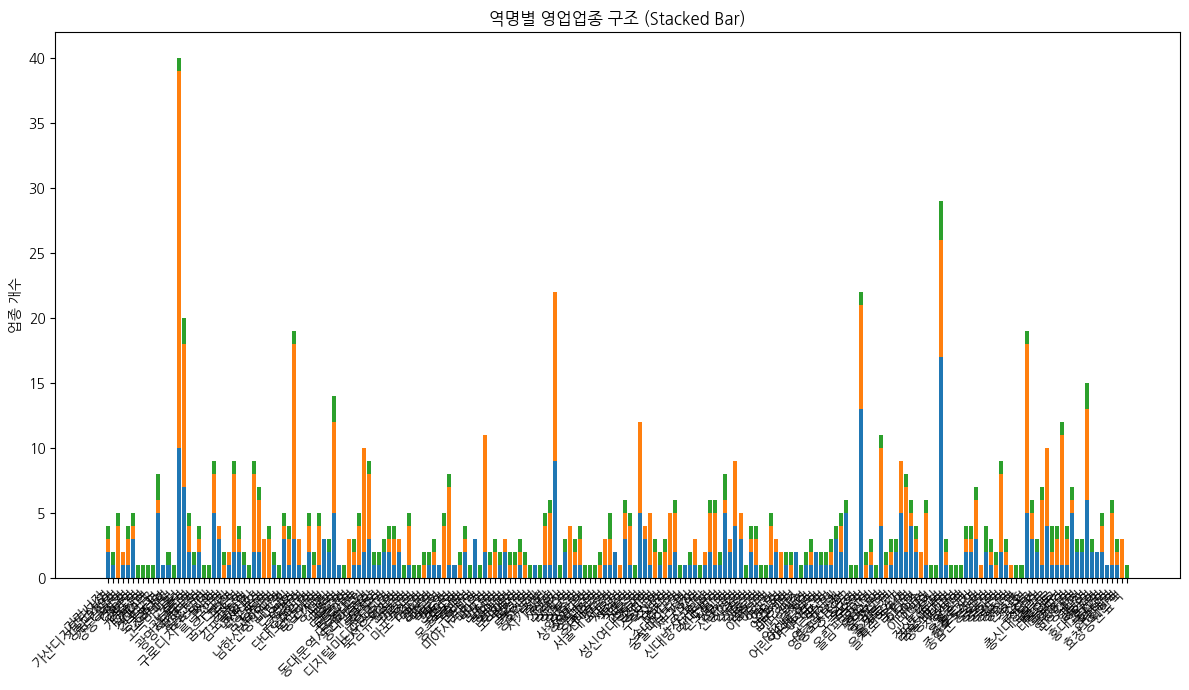

In [42]:
# 각 역에서 각 업종이 얼마나 분포하는가
# 1) pivot table 생성 (stacked bar 용)
pivot_df = count_df.pivot(index="역명", columns="영업업종", values="count").fillna(0)

# ---------------------------
# 🎨 Stacked Bar Chart
# ---------------------------
plt.figure(figsize=(12, 7))

bottom = None
for col in pivot_df.columns:
    if bottom is None:
        plt.bar(pivot_df.index, pivot_df[col])
        bottom = pivot_df[col].copy()
    else:
        plt.bar(pivot_df.index, pivot_df[col], bottom=bottom)
        bottom += pivot_df[col]

plt.xticks(rotation=45, ha="right")
plt.ylabel("업종 개수")
plt.title("역명별 영업업종 구조 (Stacked Bar)")
plt.tight_layout()
plt.show()

In [ ]:
"""
✅ 3. 업종별 분석
- 업종별 평균 임대료
- 업종별 면적당 임대료
- 업종별 계약기간 평균
"""

